<a href="https://colab.research.google.com/github/ttogle918/AI_projects/blob/master/sprint2_cinema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie rating이 3.5점이상인가? 예측

## 파일 가져오기 및 패키지 정의

In [1]:
# google 드라이브에 로컬 파일 업로드
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import ast
import re
from collections import Counter

In [3]:
import ast
def getDataFrame(s) :
  if s[0] == '\'' :
    s = s[1:-1]
  if str(s)[0] == '{' :
    df = pd.DataFrame([ast.literal_eval(s)])
  if str(s)[0] == '[' :
    df = pd.DataFrame(ast.literal_eval(s))
  else :
    df = s
    print(s)
  return df

In [4]:
credits = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/credits.csv")
keywords = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/keywords.csv")
links = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/links.csv")
links = links.append(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/links_small.csv"))
movies_metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/movies_metadata.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/ratings.csv")
ratings = ratings.append(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/ratings_small.csv"))

credits.shape, keywords.shape, links.shape, movies_metadata.shape, ratings.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((45476, 3), (46419, 2), (54968, 3), (45466, 24), (26124293, 4))

|  <center>credit</center> |  <center>cast</center> |
|:--------:|:--------|
|**credit** |cast(id, keywords), crew(credit_id, de), id> |
|**keywords** | id (id, name), keywords(id) |
|**links** | movieId, imdbId, tmdbId |
|**movies_metadata** | adult, belongs_to_collection, budget, genres |
|**''** | homepage, id, imdb_id, original_language |
|**''** | original_title, overview, popularity, poster_path |
|**''** | production_companies, production_countries |
|**''** | release_date, revenue, runtime, spoken_languages |
|**''** | status, tagline, title, video, vote_average, vote_count |
|**ratings** | userId, movieId, rating, timestamp |

## credits : 극 중 등장인물에 대한 정보와 제작진에 대한 정보를 담고있는 dataframe
이 credits의 데이터 중 우리는 배우의 이름과 책임 감독의 이름만 궁금할 것이다.

그러므로 cast에서는 상위 3명(주연), crew에서는 상위 1명(감독 혹은 작가)을 뽑아내었다.
#### 과연 주연과 감독/PD가 영화 판매수익에 영향을 미칠까?

In [5]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


1. data 불러오기
2. 중복된 값 지우기
3. null값, empty값 확인 -> 지우기
4. cast에서 배우 이름 따로 저장, crew에서 감독 이름 따로 저장

In [6]:
credits.duplicated().sum()

37

In [7]:
credits = credits.drop_duplicates()

In [8]:
print('empty cast', len(credits[credits.cast == '[]']) )
print('empty crew', len(credits[credits.crew == '[]']) )

empty cast 2414
empty crew 771


In [9]:
# delete empty cells
credits = credits[(credits.cast != '[]') & (credits.crew != '[]')]
credits.shape

(42675, 3)

In [10]:
print(len(credits['id'].unique())) # id당 한 row가 아니다!

42668


In [11]:
# cast의 내용은 같고 credit_id의 값만 다르기 때문에 삭제해도 된다 -> id는 unique()
credits = credits.drop(credits[credits['id'].duplicated() == True].index)
print(credits.shape)
credits.head(3)

(42668, 3)


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


### cast

In [12]:
# string 형태로 data 형태 바꾸기
li = [entry['name'] for entry in  ast.literal_eval(credits.cast[0])[0:4]]
li

['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney']

In [13]:
# cast 상위 8명만
import re

def set_list_to_string(s, idx, to) :
  if to == 0 :
    t_dict = ast.literal_eval(s)
    return [re.sub(r'[^\w]', '_',re.sub(r'[^\w\s]', '', entry[idx])) for entry in t_dict]
  
  t_dict = ast.literal_eval(s)[0:to]
  return [re.sub(r'[^\w]', '_',re.sub(r'[^\w\s]', '', entry[idx])) for entry in t_dict]

In [14]:
credits['actors'] = credits.cast.apply(set_list_to_string, idx='name', to=8)
credits['actors'].head(10)

0    [Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney...
1    [Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...
2    [Walter_Matthau, Jack_Lemmon, AnnMargret, Soph...
3    [Whitney_Houston, Angela_Bassett, Loretta_Devi...
4    [Steve_Martin, Diane_Keaton, Martin_Short, Kim...
5    [Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Vo...
6    [Harrison_Ford, Julia_Ormond, Greg_Kinnear, An...
7    [Jonathan_Taylor_Thomas, Brad_Renfro, Rachael_...
8    [JeanClaude_Van_Damme, Powers_Boothe, Dorian_H...
9    [Pierce_Brosnan, Sean_Bean, Izabella_Scorupco,...
Name: actors, dtype: object

In [15]:
# 가장 많이 나온 배우 40명을 most_popular_acctors이라고 가정
from collections import Counter

actor_count = Counter([name for names_per_film in credits.actors.values for name in names_per_film])
most_popular_actors = [entry[0] for entry in actor_count.most_common(40)]
credits['number_of_named_actors'] = credits['actors'].apply(len)
credits.head(3)

,cast,crew,id,actors,number_of_named_actors
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney...",8
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...",8
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[Walter_Matthau, Jack_Lemmon, AnnMargret, Soph...",7


In [16]:
def listToString(item_list):
  return r' '.join(item_list)

credits['actors'] = credits['actors'].apply(listToString)

### Crew

In [17]:
credits['crew'] = credits.crew.apply(set_list_to_string, idx='name', to=4)
credits.crew[0]

['John_Lasseter', 'Joss_Whedon', 'Andrew_Stanton', 'Joel_Cohen']

In [18]:
# 가장 많이 나온 crew 40명을 most_popular_crew라고 가정
from collections import Counter

crew_count = Counter([name for names_per_film in credits.crew.values for name in names_per_film])
most_popular_crews = [entry[0] for entry in crew_count.most_common(40)]
credits['number_of_named_crews'] = credits['crew'].apply(len)

credits['crew'] = credits['crew'].apply(listToString)
credits.head(3)

,cast,crew,id,actors,number_of_named_actors,number_of_named_crews
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...",John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,4
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,4
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,4


In [19]:
credits = credits.drop(['cast'], axis=1)

### 배우들이 영화에 주연으로 출연한 수에 따른 그래프와 영화에 참여한 크루의 수 

In [20]:
x_value = list()
y_value = list()
for i in range(40) :
  x_value.append(actor_count.most_common(40)[i][0])
  y_value.append(actor_count.most_common(40)[i][1])

df_actor_count = pd.DataFrame(data={'actor':x_value, 'count':y_value})
df_actor_count.head(10)

,actor,count
0,Christopher_Lee,115
1,John_Wayne,112
2,Jackie_Chan,103
3,Gérard_Depardieu,103
4,Michael_Caine,102
5,Robert_De_Niro,100
6,Samuel_L_Jackson,97
7,Donald_Sutherland,92
8,Danny_Glover,86
9,Harvey_Keitel,85


In [21]:
x_value = list()
y_value = list()
for i in range(40) :
  x_value.append(crew_count.most_common(40)[i][0])
  y_value.append(crew_count.most_common(40)[i][1])

df_crew_count = pd.DataFrame(data={'crew':x_value, 'count':y_value})
df_crew_count.head(10)

,crew,count
0,Cedric_Gibbons,189
1,Avy_Kaufman,132
2,Roger_Corman,127
3,Max_Steiner,122
4,Ennio_Morricone,116
5,Darryl_F_Zanuck,116
6,Charlie_Chaplin,115
7,Luc_Besson,108
8,Werner_Herzog,104
9,Hal_B_Wallis,102


In [22]:
credits.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,4
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,4
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,4


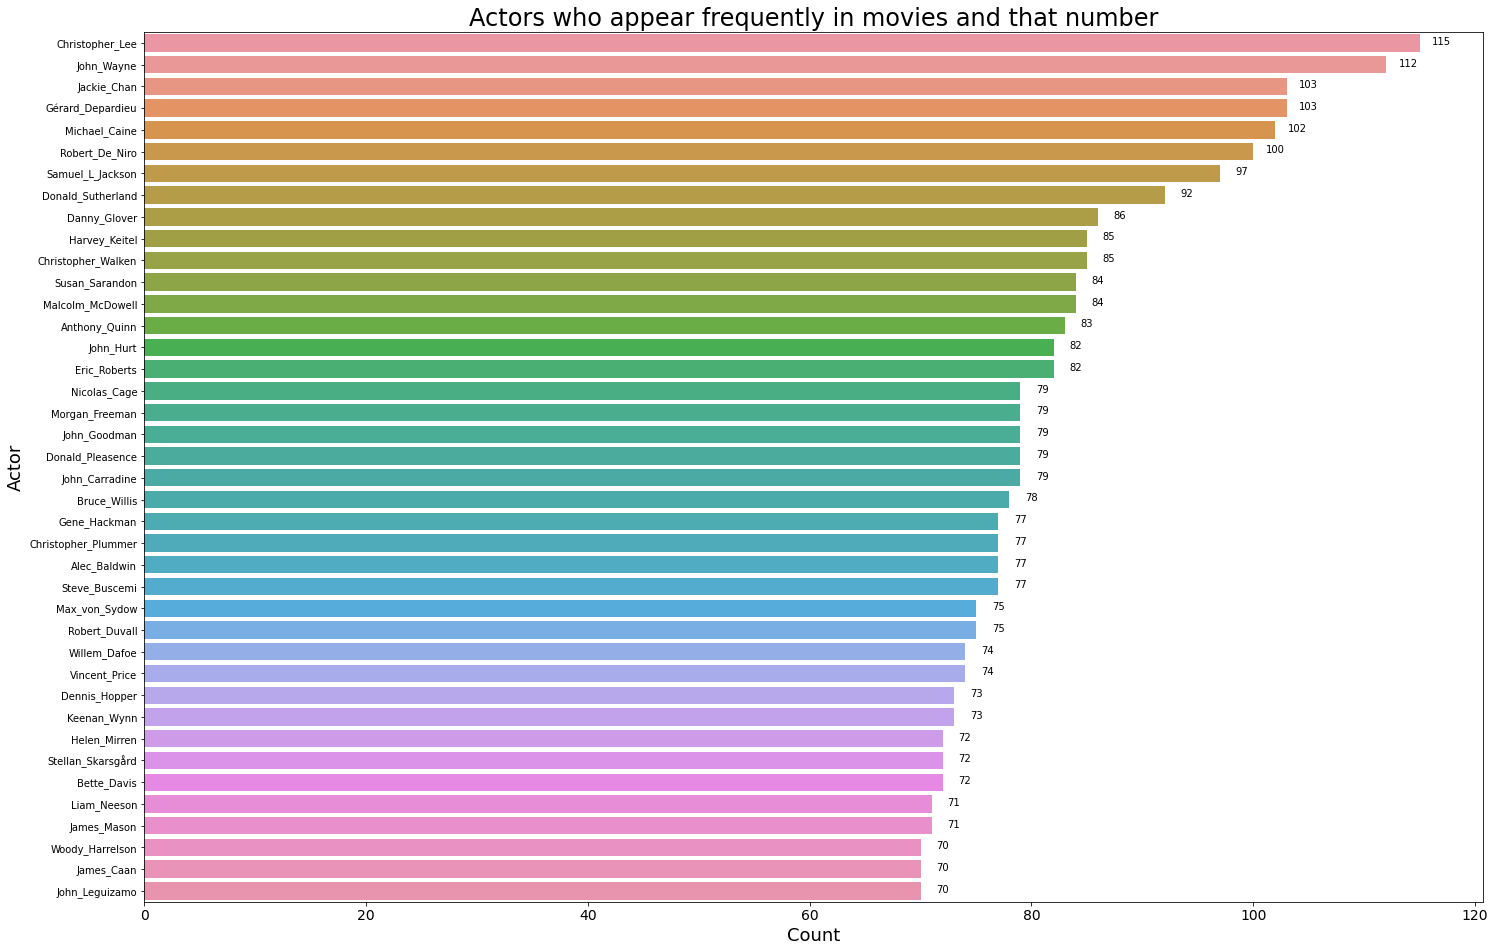

In [23]:
# Count of Actors in the Movie
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(24, 16))

g = sns.barplot(data= df_actor_count, x= "count",y= "actor", ci=None)
ax = g

#annotate axis = seaborn axis 
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width()+2, p.get_y()+p.get_height()), 
       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

plt.xticks(fontsize=14, rotation=0)
plt.title("Actors who appear frequently in movies and that number", fontsize=24)
plt.xlabel('Count', fontsize=18)
plt.ylabel('Actor', fontsize=18)

plt.show()

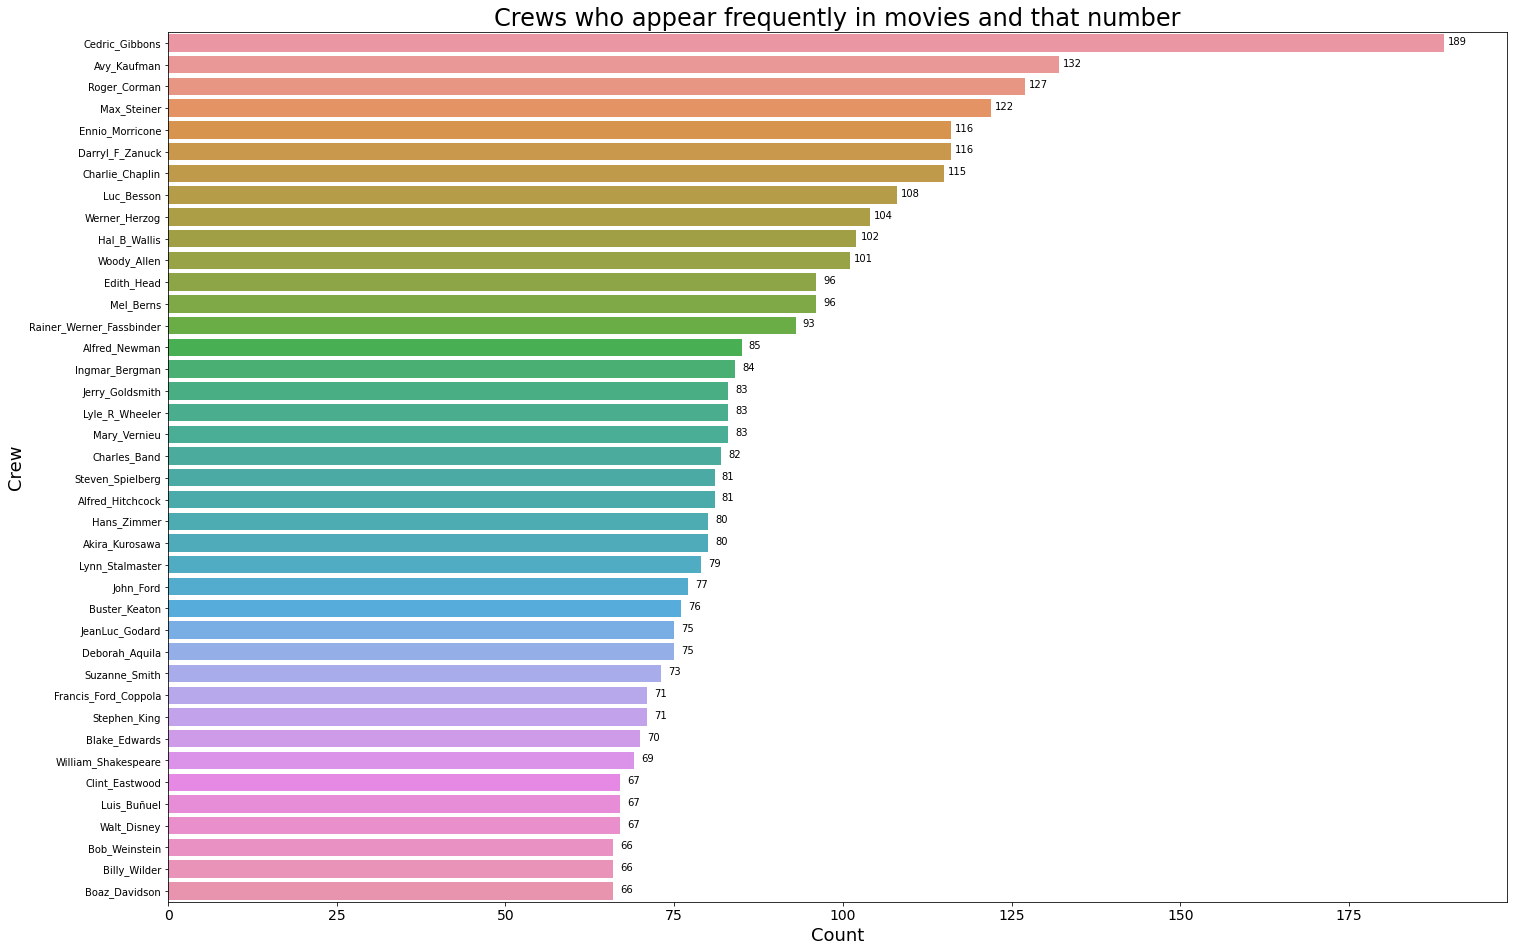

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(24, 16))

g = sns.barplot(data= df_crew_count, x= "count",y= "crew", ci=None)
ax = g

#annotate axis = seaborn axis 
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width()+2, p.get_y()+p.get_height()), 
       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

plt.xticks(fontsize=14, rotation=0)
plt.title("Crews who appear frequently in movies and that number", fontsize=24)
plt.xlabel('Count', fontsize=18)
plt.ylabel('Crew', fontsize=18)

plt.show()

## keywords : 극 중 키워드 단어를 담고있는 dataframe
-> keyword_name에 극 중 키워드 단어를 처리하기 쉬운 형태로 저장한다.

#### 과연 키워드가 영화 판매수익에 영향을 미칠까?

In [25]:
# 0번째 list로 test
[entry['name'] for entry in  ast.literal_eval(keywords.keywords[0])]

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friends',
 'rivalry',
 'boy next door',
 'new toy',
 'toy comes to life']

In [26]:
# dic형식으로 된 내용을 name컬럼만 빼서 list로 저장
keywords['keywords'] = keywords.keywords.apply(set_list_to_string, idx='name', to=0)
keywords.head(3)

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board_game, disappearance, based_on_childrens..."
2,15602,"[fishing, best_friend, duringcreditsstinger, o..."


In [27]:
# 가장 많이 나온 키워드 40개를 most_popular_keywords라고 가정

from collections import Counter

keyword_count = Counter([name for names_per_film in keywords.keywords.values for name in names_per_film])
most_popular_keywords = [entry[0] for entry in keyword_count.most_common(40)]
keywords['number_of_named_keyword'] = keywords['keywords'].apply(len)

# 아래 시각화를 위해서 정의
x_value = list()
y_value = list()
for i in range(40) :
  x_value.append(keyword_count.most_common(40)[i][0])
  y_value.append(keyword_count.most_common(40)[i][1])

df_keyword_count = pd.DataFrame(data={'keyword':x_value, 'count':y_value})
df_keyword_count.head(10)

,keyword,count
0,woman_director,3115
1,independent_film,1930
2,murder,1308
3,based_on_novel,835
4,musical,734
5,sex,685
6,violence,651
7,nudity,636
8,biography,629
9,revenge,626


In [28]:
keywords['keywords'] = keywords['keywords'].apply(listToString)
keywords.head(3)

,id,keywords,number_of_named_keyword
0,862,jealousy toy boy friendship friends rivalry bo...,9
1,8844,board_game disappearance based_on_childrens_bo...,6
2,15602,fishing best_friend duringcreditsstinger old_men,4


In [29]:
keywords['keywords'].unique()

array(['jealousy toy boy friendship friends rivalry boy_next_door new_toy toy_comes_to_life',
       'board_game disappearance based_on_childrens_book new_home recluse giant_insect',
       'fishing best_friend duringcreditsstinger old_men', ...,
       'blair_witch', 'witch mythology legend serial_killer mockumentary',
       'artist play pinoy'], dtype=object)

### keywords의 수 합계 그래프

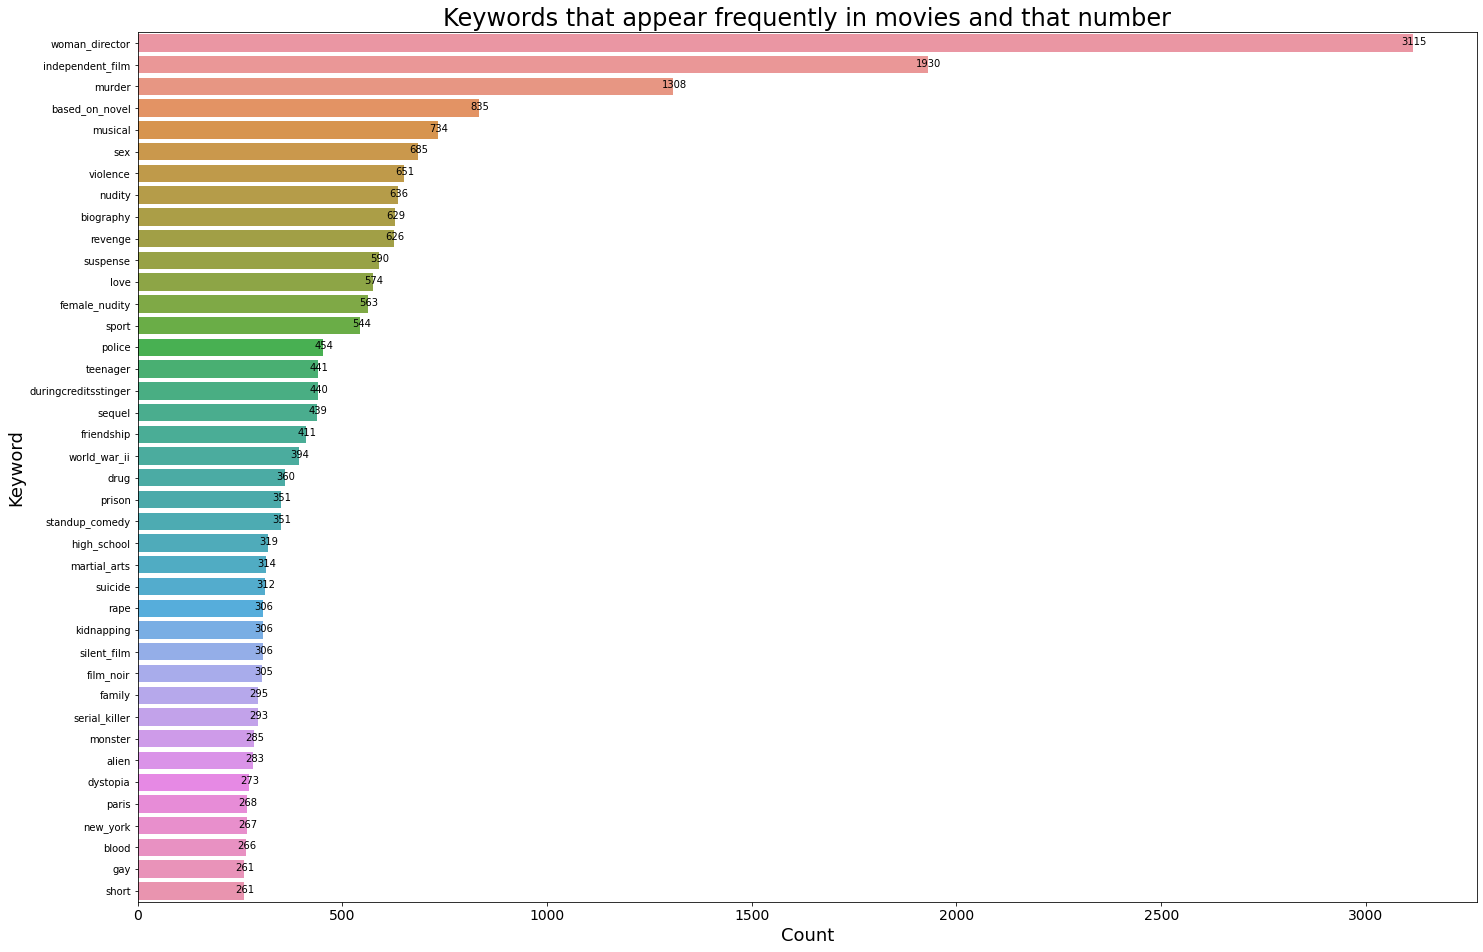

In [30]:
# Keywords that appear frequently in movies and that number
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(24, 16))
g = sns.barplot(data= df_keyword_count, x= "count",y= "keyword", ci=None)
ax = g

#annotate axis = seaborn axis 
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width()+2, p.get_y()+p.get_height()), 
       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

plt.xticks(fontsize=14, rotation=0)
plt.title("Keywords that appear frequently in movies and that number", fontsize=24)
plt.xlabel('Count', fontsize=18)
plt.ylabel('Keyword', fontsize=18)
plt.show()

## credit과 keywords merge

In [31]:
merged_df = pd.merge(credits, keywords, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,4,jealousy toy boy friendship friends rivalry bo...,9
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,4,board_game disappearance based_on_childrens_bo...,6
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,4,fishing best_friend duringcreditsstinger old_men,4


## links : 극 중 키워드 단어를 담고있는 dataframe
-> keyword_name에 극 중 키워드 단어를 처리하기 쉬운 형태로 저장한다.

#### 과연 키워드가 영화 판매수익에 영향을 미칠까?

In [32]:
links.columns = ['movieId', 'imdbId', 'id']
links.head(1)

,movieId,imdbId,id
0,1,114709,862.0


In [33]:
links = links.drop_duplicates()

In [34]:
links.isnull().sum()

movieId      0
imdbId       0
id         222
dtype: int64

## merge


In [35]:
merged_df = pd.merge(merged_df, links, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword,movieId,imdbId
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,4,jealousy toy boy friendship friends rivalry bo...,9,1,114709
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,4,board_game disappearance based_on_childrens_bo...,6,2,113497
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,4,fishing best_friend duringcreditsstinger old_men,4,3,113228


## movies_metadata : 영화에 대한 정보를 담고있는 dataframe
-> 예측할 때 필요한 정보만 남겨놓았다.

#### 과연 예산과 장르, 상영시간, 판매회사가 영화 판매수익에 영향을 미칠까?

+ movies_metadata에서 필요없는 컬럼 삭제 ( ['original_language', 'original_title', 'overview', 'poster_path', 'tagline'] )
+ homepage컬럼은 유/무로 판단(있다면 1, 없다면 0)
+ spoken_languages는 언어가 몇가지인지로 적는다. ( 이 영화에 대한 기대감과 투자의 정도를 알 수 있을 것이다. )

In [36]:
movies_metadata.duplicated().sum()

13

In [37]:
movies_metadata = movies_metadata.drop_duplicates()

In [38]:
print(movies_metadata.shape)
movies_metadata.head(2)

(45453, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [39]:
print(movies_metadata.revenue.mean())
print(movies_metadata.revenue.median())
movies_metadata.status.unique()

11212544.046889784
0.0


array(['Released', nan, 'Rumored', 'Post Production', 'In Production',
       'Planned', 'Canceled'], dtype=object)

In [40]:
movies_metadata.isnull().sum()

adult                        0
belongs_to_collection    40959
budget                       0
genres                       0
homepage                 37673
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25045
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [41]:
movies_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [42]:
def toint(s) :
  try :
    n = int(s)
    return n
  except :
    print(s)
    return s
movies_metadata.budget.apply(toint)

/ff9qCepilowshEtG2GYWwzt2bs4.jpg
/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg
/zaSf5OG7V8X8gqFvly88zDdRm46.jpg


0        30000000
1        65000000
2               0
3        16000000
4               0
           ...   
45461           0
45462           0
45463           0
45464           0
45465           0
Name: budget, Length: 45453, dtype: object

In [43]:
# 본인의 columns 위치가 아닌 곳에 데이터가 있는 data들 drop
movies_metadata[movies_metadata.budget == '/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/ff9qCepilowshEtG2GYWwzt2bs4.jpg'].index)
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg'].index)
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/zaSf5OG7V8X8gqFvly88zDdRm46.jpg'].index)
print(movies_metadata.shape)
movies_metadata.id = movies_metadata.id.astype(int)

(45450, 24)


In [45]:
# nan 값을 0으로 치환(없다고 가정한다)
movies_metadata.poster_path = movies_metadata.poster_path.fillna(0)

In [46]:
def set_poster(s) :
  if s == 0 :
    return 0
  else :
    return 1
  return 0
movies_metadata.poster_path = movies_metadata.poster_path.apply(set_poster)
movies_metadata.columns = ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count']
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count'],
      dtype='object')

In [47]:
print(movies_metadata.adult.unique())
print(movies_metadata.status.unique())
print(movies_metadata.video.unique())

['False' 'True']
['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']
[False True nan]


In [48]:
# False가 대부분이고, True는 극소수(대략 0.02%)이므로 통계적으로 의미를 띄지않는다.(유의미하지않다.) -> drop
Counter(movies_metadata.adult)

Counter({'False': 45441, 'True': 9})

In [49]:
# belongs_to_collection 컬럼에 빈칸(nan)값이 많기 때문에 우리가 예측하고자 하는 바에 도움이 되지 않는다. -> drop
movies_metadata.shape, movies_metadata.belongs_to_collection.isnull().sum()

((45450, 24), 40959)

In [50]:
# dic형식으로 된 내용을 name컬럼만 빼서 list로 저장
movies_metadata['genres'] = movies_metadata.genres.apply(set_list_to_string, idx='name', to=0)
movies_metadata['number_of_popular_genres'] = movies_metadata['genres'].apply(len)

movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,3
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,2


In [51]:
# 가장 많이 나온 crew 40명을 most_popular_genres라고 가정
from collections import Counter

genre_count = Counter([name for names_per_film in movies_metadata.genres.values for name in names_per_film])
most_popular_genres = [entry[0] for entry in genre_count.most_common(40)]

movies_metadata['genres'] = movies_metadata['genres'].apply(listToString)

movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,3
1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,Romance Comedy,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,2


In [52]:
genre_count

Counter({'Action': 6594,
         'Adventure': 3495,
         'Animation': 1933,
         'Comedy': 13180,
         'Crime': 4306,
         'Documentary': 3932,
         'Drama': 20255,
         'Family': 2770,
         'Fantasy': 2311,
         'Foreign': 1620,
         'History': 1398,
         'Horror': 4672,
         'Music': 1598,
         'Mystery': 2465,
         'Romance': 6734,
         'Science_Fiction': 3046,
         'TV_Movie': 767,
         'Thriller': 7621,
         'War': 1323,
         'Western': 1042})

In [53]:
# Released는 train data로, Planned, In Production, Post Production은 test 데이터로
Counter(movies_metadata.status)

Counter({'Canceled': 2,
         'In Production': 20,
         'Planned': 15,
         'Post Production': 98,
         'Released': 45002,
         'Rumored': 229,
         nan: 84})

In [54]:
# False가 대부분이므로 video feature 삭제
Counter(movies_metadata.video)

Counter({False: 45354, True: 93, nan: 3})

In [55]:
# 1(포스터가 존재)이 대부분이므로 유의미하지 않다.
Counter(movies_metadata.poster)

Counter({0: 386, 1: 45064})

In [56]:
movies_metadata[movies_metadata.spoken_languages.isnull() == True].index

Int64Index([19729, 29502, 35586], dtype='int64')

In [57]:
print(movies_metadata.shape)
movies_metadata = movies_metadata.dropna()
print(movies_metadata.shape)

(45450, 25)
(693, 25)


In [58]:
# 홈페이지가 존재한다면 1, 없다면 0으로 치환
def setHomepage(s) :
  if s == 0 :
    return 0
  s = str(s)
  if s[0:4] == 'http' :
    return 1
  return 0
movies_metadata.fillna(0) # homepage가 없는 경우 0
movies_metadata.homepage = movies_metadata.homepage.apply(setHomepage)


# 음성언어가 몇가지 있는지 치환
movies_metadata.spoken_languages = movies_metadata.spoken_languages.apply(set_list_to_string, idx='name', to=0)
movies_metadata.spoken_languages = movies_metadata.spoken_languages.apply(len)
movies_metadata.spoken_languages.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


9      3
68     1
69     2
153    1
178    1
Name: spoken_languages, dtype: int64

In [59]:
Counter(movies_metadata.homepage) # 대략 1의 비율이 17% -> 남겨둔다.

Counter({1: 693})

In [60]:
len(movies_metadata[ (movies_metadata['revenue'] == 0) ])

191

In [61]:
movies_metadata[ (movies_metadata['video'] == False) ].revenue

9        352194034.0
68        28215918.0
69        25836616.0
153        1275000.0
178       66000000.0
            ...     
44274    369907963.0
44674            0.0
44821     68411275.0
44842    604942143.0
45029            0.0
Name: revenue, Length: 692, dtype: float64

Text(0, 0.5, 'revenue')

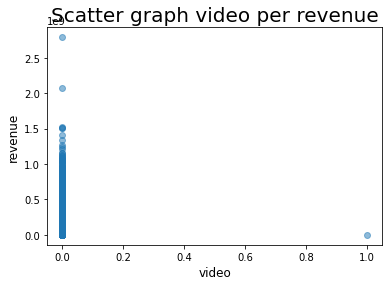

In [62]:
import matplotlib.pyplot as plt
plt.scatter(movies_metadata['video'], movies_metadata['revenue'], alpha = .5)
plt.title('Scatter graph video per revenue', fontsize=20)
plt.xlabel('video', fontsize=12)
plt.ylabel('revenue', fontsize=12)

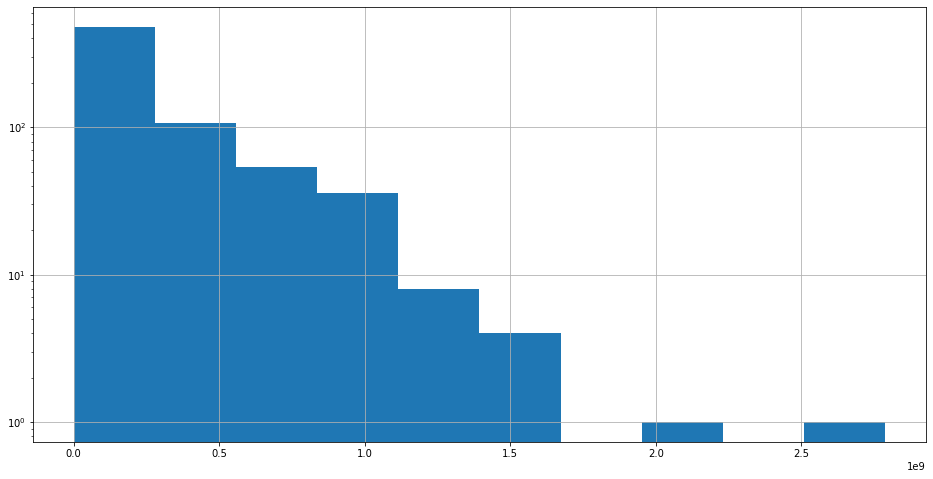

In [63]:
movies_metadata[movies_metadata['video']==False].revenue.hist(figsize=(16,8), log=True);

In [64]:
# 출시된 상태의 영화에 대해서 훈련시킬 예정이다.
movies_metadata = movies_metadata[ (movies_metadata['status'] == 'Released') | (movies_metadata['status'] == 'Planned') 
                    | (movies_metadata['status'] == 'In Production') | (movies_metadata['status'] == 'Post Production')]
print(movies_metadata.status.unique())

['Released']


In [65]:
movies_metadata.describe(include='all')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres
count,693,693,693,693,693.0,693.000000,693,693,693,693,693,693.0,693,693,693,6.930000e+02,693.000000,693.000000,693,693,693,693,693.000000,693.000000,693.000000
unique,1,423,164,333,NaN,NaN,692,21,688,691,693,NaN,555,107,646,NaN,NaN,NaN,1,685,687,2,NaN,NaN,NaN
top,False,"{'id': 645, 'name': 'James Bond Collection', '...",0,Comedy,NaN,NaN,tt0235679,en,Halloween,When Molly Hale's sadness of her father's disa...,9.914008,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2013-07-11,NaN,NaN,NaN,Released,Who is John Galt?,Ghostbusters,False,NaN,NaN,NaN
freq,693,25,175,37,NaN,NaN,2,610,2,2,1,NaN,31,396,3,NaN,NaN,NaN,693,3,2,692,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.0,75374.291486,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.348037e+08,107.363636,1.559885,NaN,NaN,NaN,NaN,6.270996,1691.366522,2.797980
std,NaN,NaN,NaN,NaN,0.0,101321.301068,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,3.299089e+08,27.243771,1.038817,NaN,NaN,NaN,NaN,1.012328,2215.285619,1.098947
min,NaN,NaN,NaN,NaN,1.0,11.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,1.0,8359.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.000000e+00,91.000000,1.000000,NaN,NaN,NaN,NaN,5.800000,121.000000,2.000000
50%,NaN,NaN,NaN,NaN,1.0,33303.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,8.332000e+07,103.000000,1.000000,NaN,NaN,NaN,NaN,6.300000,688.000000,3.000000
75%,NaN,NaN,NaN,NaN,1.0,91586.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.613666e+08,121.000000,2.000000,NaN,NaN,NaN,NaN,7.000000,2491.000000,3.000000


imdb_id는 id값이기 때문에 실제 값으로 보기 힘들다. ->drop

vote_count도 count한 통계결과이기 때문에 유의미하지않다. ->drop

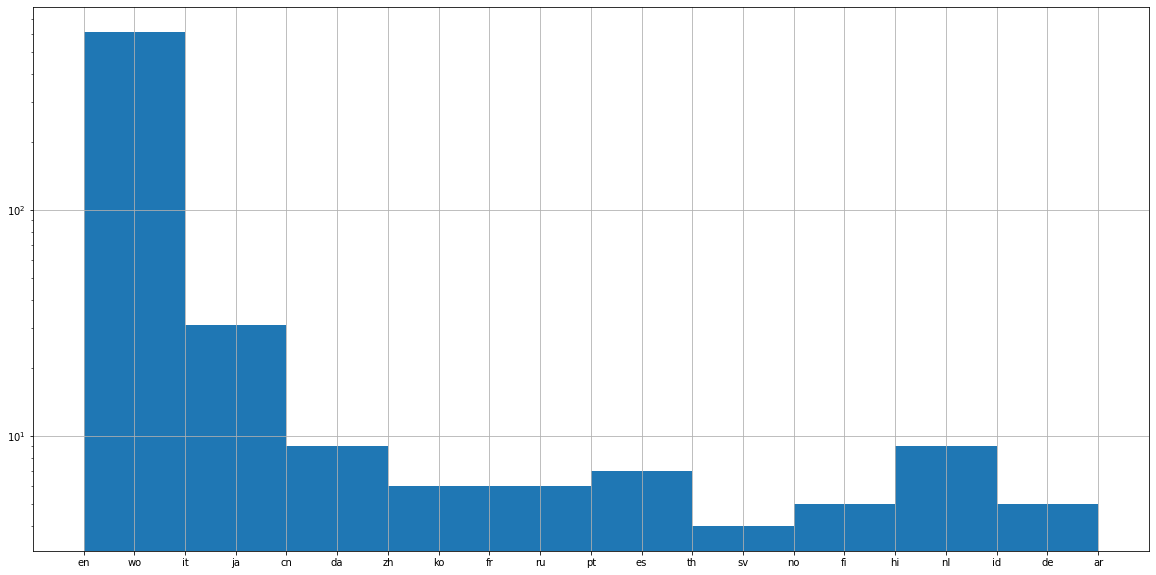

In [66]:
movies_metadata['original_language'].hist(figsize=(20,10), log=True);

In [67]:
movies_metadata = movies_metadata.drop(['adult', 'poster', 'belongs_to_collection', 'imdb_id', 'vote_count', 
                                        'original_language', 'original_title', 'overview', 'tagline', 'video'], axis=1)
movies_metadata.head(2)

,budget,genres,homepage,id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres
9,58000000,Adventure Action Thriller,1,710,14.686,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3
68,3500000,Comedy,1,10634,14.5696,"[{'name': 'New Line Cinema', 'id': 12}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1


In [68]:
movies_metadata['id'] = movies_metadata['id'].astype(int)

In [69]:
movies_metadata.isnull().sum()

budget                      0
genres                      0
homepage                    0
id                          0
popularity                  0
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      0
title                       0
vote_average                0
number_of_popular_genres    0
dtype: int64

In [70]:
print(movies_metadata.runtime.min())
print(movies_metadata.runtime.max())
print(len(movies_metadata[movies_metadata.runtime < 60]))

0.0
476.0
12


In [71]:
movies_metadata = movies_metadata.drop( movies_metadata[movies_metadata['runtime'] < 60 ].index)
print(movies_metadata.shape)
movies_metadata.head(2)

(681, 15)


,budget,genres,homepage,id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres
9,58000000,Adventure Action Thriller,1,710,14.686,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3
68,3500000,Comedy,1,10634,14.5696,"[{'name': 'New Line Cinema', 'id': 12}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1


## merge

In [72]:
merged_df = pd.merge(merged_df, movies_metadata, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword,movieId,imdbId,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres
0,Martin_Campbell Ian_Fleming Jeffrey_Caine Bruc...,710,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,8,4,cuba falsely_accused secret_identity computer_...,15,10,113189,58000000,Adventure Action Thriller,1,14.686,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3
1,F_Gary_Gray DJ_Pooh Ice_Cube Frank_Fitzpatrick,10634,Ice_Cube Chris_Tucker Nia_Long Tom_Lister_Jr J...,8,4,rap_music parent_child_relationship rapper job,4,69,113118,3500000,Comedy,1,14.5696,"[{'name': 'New Line Cinema', 'id': 12}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1
2,Robert_Rodriguez Quentin_Tarantino Quentin_Tar...,755,George_Clooney Quentin_Tarantino Harvey_Keitel...,8,4,dancing brother_brother_relationship sexual_ob...,26,70,116367,19000000,Horror Action Thriller Crime,1,15.3392,"[{'name': 'A Band Apart', 'id': 59}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-01-19,25836616.0,108.0,2,Released,From Dusk Till Dawn,6.9,4


## ratings : 영화에 대한 평점을 담고있는 dataframe
-> 예측할 때 필요한 정보만 남겨놓았다.

#### 과연 ?

In [73]:
ratings = ratings.drop_duplicates(ignore_index=True)  # 중복값 없음
print(ratings.shape)

(26124293, 4)


In [74]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [75]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


In [76]:
ratings = ratings.drop(['userId', 'timestamp'], axis=1)
ratings['rating'].unique()

array([1. , 4.5, 5. , 4. , 3.5, 2.5, 0.5, 3. , 2. , 1.5])

In [77]:
grouped_rating = (ratings.groupby(by="movieId").mean())['rating'].to_frame()
grouped_rating['rating'] = grouped_rating['rating'].round(1)
grouped_rating = grouped_rating.reset_index()

grouped_rating.head(3)

,movieId,rating
0,1,3.9
1,2,3.2
2,3,3.2


In [78]:
grouped_rating.rating.mean(), grouped_rating.rating.median()

(3.0617113223854715, 3.2)

In [79]:
def transform_rating(n) :
  if n >= 3.2 :
    return True
  return False

grouped_rating['rating'] = grouped_rating['rating'].apply(transform_rating)

## merge

In [80]:
merged_df = pd.merge(merged_df, grouped_rating, how='inner', on='movieId')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword,movieId,imdbId,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres,rating
0,Martin_Campbell Ian_Fleming Jeffrey_Caine Bruc...,710,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,8,4,cuba falsely_accused secret_identity computer_...,15,10,113189,58000000,Adventure Action Thriller,1,14.686,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3,True
1,F_Gary_Gray DJ_Pooh Ice_Cube Frank_Fitzpatrick,10634,Ice_Cube Chris_Tucker Nia_Long Tom_Lister_Jr J...,8,4,rap_music parent_child_relationship rapper job,4,69,113118,3500000,Comedy,1,14.5696,"[{'name': 'New Line Cinema', 'id': 12}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1,True
2,Robert_Rodriguez Quentin_Tarantino Quentin_Tar...,755,George_Clooney Quentin_Tarantino Harvey_Keitel...,8,4,dancing brother_brother_relationship sexual_ob...,26,70,116367,19000000,Horror Action Thriller Crime,1,15.3392,"[{'name': 'A Band Apart', 'id': 59}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-01-19,25836616.0,108.0,2,Released,From Dusk Till Dawn,6.9,4,True


## 학습하기 좋은 데이터 모양으로 만들기
1. unique 데이터(ex. id) drop
2. train과 test data 나누기

In [81]:
merged_df.shape, len(merged_df[merged_df['budget']==0])

((681, 24), 0)

In [82]:
# test data가 너무 부족하다 -> movies_metadata[movies_metadata['release_date'] > '2016-01-01']
final_test = merged_df[merged_df['status'] != 'Released']
train = merged_df[merged_df['status'] == 'Released']
print(train.shape)
print(final_test.shape)

(681, 24)
(0, 24)


In [83]:
print(train['vote_average'].dtype)
len(train[train['vote_average'] == 0])
print(train.shape)
train = train.drop(train[train['vote_average'] == 0].index)
print(train.shape)

float64
(681, 24)
(679, 24)


In [84]:
print(train['rating'].dtype)
len(train[train['rating'] == 0])

bool


303

In [85]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)

### 모델 훈련
#### 랜덤포레스트 모델을 적용하여 분류 예측

https://gomguard.tistory.com/173

In [86]:
# !pip install category_encoders

In [87]:
merged_df.head()

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword,movieId,imdbId,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres,rating
0,Martin_Campbell Ian_Fleming Jeffrey_Caine Bruc...,710,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,8,4,cuba falsely_accused secret_identity computer_...,15,10,113189,58000000,Adventure Action Thriller,1,14.686,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3,True
1,F_Gary_Gray DJ_Pooh Ice_Cube Frank_Fitzpatrick,10634,Ice_Cube Chris_Tucker Nia_Long Tom_Lister_Jr J...,8,4,rap_music parent_child_relationship rapper job,4,69,113118,3500000,Comedy,1,14.5696,"[{'name': 'New Line Cinema', 'id': 12}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1,True
2,Robert_Rodriguez Quentin_Tarantino Quentin_Tar...,755,George_Clooney Quentin_Tarantino Harvey_Keitel...,8,4,dancing brother_brother_relationship sexual_ob...,26,70,116367,19000000,Horror Action Thriller Crime,1,15.3392,"[{'name': 'A Band Apart', 'id': 59}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-01-19,25836616.0,108.0,2,Released,From Dusk Till Dawn,6.9,4,True
3,Paul_Auster Paul_Auster Wayne_Wang Harvey_Keitel,5894,Harvey_Keitel Lou_Reed Michael_J_Fox Roseanne_...,8,4,smoking corner_shop cigarette tobacco cigar in...,6,156,112541,2000000,Comedy,1,11.5281,"[{'name': 'Miramax Films', 'id': 14}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-09-15,1275000.0,83.0,1,Released,Blue in the Face,6.8,1,True
4,Suzanne_Todd Graeme_Revell Wayne_Wahrman Josep...,9070,Amy_Jo_Johnson Jason_David_Frank David_Yost Jo...,8,4,based_on_tv_series tokusatsu superhero_team et...,8,181,113820,15000000,Action Adventure Science_Fiction Family Fantasy,1,7.02423,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",1995-06-30,66000000.0,92.0,1,Released,Mighty Morphin Power Rangers: The Movie,5.2,5,False


In [88]:
import seaborn as sns
corr = merged_df.corr()
corr['rating']
df_target_corr = corr[['rating']].sort_values('rating', ascending=False)
df_target_corr

,rating
rating,1.000000
vote_average,0.629139
revenue,0.241846
number_of_named_keyword,0.239403
runtime,0.234049
spoken_languages,0.139970
number_of_named_crews,0.065205
number_of_popular_genres,0.039117
number_of_named_actors,0.011900
id,-0.121724


In [89]:
# vote_count == 0  지우기.
# production_countries 지우기 -> 상관계수에 안나옴
# crew 안나옴 지우자
# actors 안나옴 -> 지우자
# budget == 0 이 많은가? 상관계수 안뜸
# genres 고쳐야함
# poster 없앨까... 0.008?
# released data 없애자.
# title 없애자

In [90]:
target = 'rating'
features = ['vote_average', 'runtime', 'spoken_languages', 'revenue', 'homepage', 'number_of_named_crews', 'number_of_named_actors']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

X_train.shape, X_val.shape, X_test.shape

((434, 7), (109, 7), (136, 7))

In [91]:
# coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
# coefficients

In [92]:
from sklearn.metrics import accuracy_score

major = y_train.mode()[0]
basic_model = [major] * len(y_train)
print("기준모델과 훈련용 데이터 학습 정확도 :", accuracy_score(y_train, basic_model))

y_pred_val = [major] * len(y_val)

print("기준모델과 검증용 데이터 학습 정확도 :", accuracy_score(y_val, y_pred_val))

기준모델과 훈련용 데이터 학습 정확도 : 0.5691244239631337
기준모델과 검증용 데이터 학습 정확도 : 0.5045871559633027


In [93]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(max_depth=7, random_state=10, n_jobs=-1, oob_score=True)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

from sklearn.metrics import f1_score

y_pred_val = pipe.predict(X_val)
print('검증 f1 score: ', f1_score(y_val, y_pred_val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


훈련 정확도:  0.9493087557603687
검증 정확도 0.8623853211009175
검증 f1 score:  0.8623853211009175


In [94]:
pipe.named_steps['randomforestclassifier'].oob_score_

0.8640552995391705

In [95]:
y_pred = pipe.predict(X_train)
print('predict 전 test 정확도: ', pipe.score(X_test, y_test))

from sklearn.metrics import f1_score
print('test f1 score: ', f1_score(y_train, y_pred))

predict 전 test 정확도:  0.8970588235294118
test f1 score:  0.9551020408163265


In [96]:
enc = pipe.named_steps['ordinalencoder']
encoded = enc.transform(X_train)

print('Ordinal  shape: ', encoded.shape)

Ordinal  shape:  (434, 7)


In [97]:
# y_pred = pipe.predict(final_test[features])
# y_pred

ValueError: ignored

In [ ]:
print('predict 전 test 정확도: ', pipe.score(X_test, y_test))